In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

In [32]:
# Classification: Can we predict whether a particular car model will be a "best-seller" (yes/no) based on
# features, historical sales data, and marketing efforts.
file_path = "../data/processed/vehicle_sales_model_ready.parquet"
df = pd.read_parquet(file_path)

df = df.drop(columns=["family_size", "gender", "annual_income", "company", "model"])

print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   price             23906 non-null  int64   
 1   mileage_km_total  23906 non-null  int64   
 2   crash_test_score  23906 non-null  int64   
 3   body_style        23906 non-null  category
 4   color             23906 non-null  category
 5   transmission      23906 non-null  category
 6   dealer_region     23906 non-null  category
 7   brand_model       23906 non-null  category
 8   engine            23906 non-null  category
 9   year              23906 non-null  int32   
 10  month             23906 non-null  int32   
dtypes: category(6), int32(2), int64(3)
memory usage: 916.8 KB
None


,price,mileage_km_total,crash_test_score,body_style,color,transmission,dealer_region,brand_model,engine,year,month
0,26000,68468,4,SUV,Black,Auto,Middletown,Ford-Expedition,Double Overhead Camshaft,2022,1
1,19000,64053,3,SUV,Black,Auto,Aurora,Dodge-Durango,Double Overhead Camshaft,2022,1
2,31500,24942,5,Passenger,Red,Manual,Greenville,Cadillac-Eldorado,Overhead Camshaft,2022,1


In [33]:
# Add a new feature to indicate if the car model is a best-seller
# For simplicity, let's assume a model is a best-seller if it is in top 3 models sold in a given year and month.

# Aggregate by year, month, and brand_model to get total number of sales
df2_agg = (
    df.groupby(["year", "month", "brand_model"])["year"].count().reset_index(name="current_month_sales")
)

# Add sales of N previous months
df2_agg = df2_agg.sort_values(by=["brand_model", "year", "month"])
for i in range(1, 13):
    df2_agg[f"last_{i}_months_sales"] = (
        df2_agg.groupby(["brand_model"])["current_month_sales"]
        .rolling(window=i, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )

# Find rank of each brand_model within a year and a month based on current_month_sales
df2_agg["rank"] = df2_agg.groupby(["year", "month"])["current_month_sales"].rank(
    method="first", ascending=False
)
df2_agg["monthly_best_seller"] = (df2_agg["rank"] <= 3).astype(int)
df2_agg.drop(columns=["rank"], inplace=True)

# Merge the aggregated data back to the original DataFrame
df3 = df.merge(df2_agg, on=["year", "month", "brand_model"], how="left")

# Export final data to a new parquet file
df3.to_parquet("../data/processed/vehicle_sales_model_ready_with_bestseller.parquet", index=False)

df3.head()

,price,mileage_km_total,crash_test_score,body_style,color,transmission,dealer_region,brand_model,engine,year,...,last_4_months_sales,last_5_months_sales,last_6_months_sales,last_7_months_sales,last_8_months_sales,last_9_months_sales,last_10_months_sales,last_11_months_sales,last_12_months_sales,monthly_best_seller
0,26000,68468,4,SUV,Black,Auto,Middletown,Ford-Expedition,Double Overhead Camshaft,2022,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0
1,19000,64053,3,SUV,Black,Auto,Aurora,Dodge-Durango,Double Overhead Camshaft,2022,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0
2,31500,24942,5,Passenger,Red,Manual,Greenville,Cadillac-Eldorado,Overhead Camshaft,2022,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1
3,14000,108673,3,SUV,Pale White,Manual,Pasco,Toyota-Celica,Overhead Camshaft,2022,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0
4,24500,51660,4,Hatchback,Red,Auto,Janesville,Acura-TL,Double Overhead Camshaft,2022,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0


In [34]:
# Prepare data for model training and testing

test_cond = (df3["year"] == 2023) & (df3["month"] >= 10)
train_df = df3[~test_cond]
test_df = df3[test_cond]
X_train = train_df.drop(columns=["monthly_best_seller"])
y_train = train_df["monthly_best_seller"]
X_test = test_df.drop(columns=["monthly_best_seller"])
y_test = test_df["monthly_best_seller"]

print("Shapes:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

dist = np.bincount(y_train)
print("\nClass distribution:", dist)
print("First class:", 100 - dist[1] / dist[0] * 100)
print("Second class:", dist[1] / dist[0] * 100)

Shapes:
(19140, 24) (19140,)
(4766, 24) (4766,)

Class distribution: [17935  1205]
First class: 93.28129356007805
Second class: 6.71870643992194


In [35]:
numeric_features = [
    "year",
    "month",
    "mileage_km_total",
    "crash_test_score",
    "current_month_sales",
    *[f"last_{i}_months_sales" for i in range(1, 13)],
    "price",
]
categorical_features = ["brand_model", "engine", "transmission", "color", "body_style", "dealer_region"]
weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = dict(zip(np.unique(y_train), weights))

In [36]:
def grid_search_pipeline(pipeline, extra_params: dict = None):
    param_grid = {
        # OneHotEncoder hyperparameters
        "preprocessor__cat__onehot__drop": [
            "first",
            None,
        ],  # Drop first column to avoid collinearity
    }
    if extra_params is not None:
        param_grid.update(extra_params)
    grid = GridSearchCV(pipeline, param_grid, scoring="f1", cv=5)
    grid.fit(X_train, y_train)

    print("Best params:", grid.best_params_)
    print("Best AUC:", grid.best_score_)
    return grid.best_estimator_

In [37]:
def evaluate_model(model):
    y_pred = model.predict(X_test)

    # Predict probabilities (for ROC, AUC, etc.)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [38]:
preprocessor = ColumnTransformer(
    [
        ("num", Pipeline([("scaler", StandardScaler())]), numeric_features),
        (
            "cat",
            Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]),
            categorical_features,
        ),
    ]
)

In [39]:
pipeline_1 = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000, class_weight=class_weights)),
    ]
)
pipeline_1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month',
                                                   'mileage_km_total',
                                                   'crash_test_score',
                                                   'current_month_sales',
                                                   'last_1_months_sales',
                                                   'last_2_months_sales',
                                                   'last_3_months_sales',
                                                   'last_4_months_sales',
                                                   'last_5_months_sales',
                                                   'last_6_months_sales',
                                                   'last_7_months_sales',
                                                   'la...
                                                   'last_9_months_sales',
                                                   'last_10_months_sales',
                                                   'last_11_months_sales',
                                                   'last_12_months_sales',
                                                   'price']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['brand_model', 'engine',
                                                   'transmission', 'color',
                                                   'body_style',
                                                   'dealer_region'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 0.5335935321996097,
                                                  1: 7.941908713692946},
                                    max_iter=1000))])

In [40]:
from sklearn.ensemble import RandomForestClassifier

pipeline_2 = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier()),
    ]
)
pipeline_2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month',
                                                   'mileage_km_total',
                                                   'crash_test_score',
                                                   'current_month_sales',
                                                   'last_1_months_sales',
                                                   'last_2_months_sales',
                                                   'last_3_months_sales',
                                                   'last_4_months_sales',
                                                   'last_5_months_sales',
                                                   'last_6_months_sales',
                                                   'last_7_months_sales',
                                                   'last_8_months_sales',
                                                   'last_9_months_sales',
                                                   'last_10_months_sales',
                                                   'last_11_months_sales',
                                                   'last_12_months_sales',
                                                   'price']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['brand_model', 'engine',
                                                   'transmission', 'color',
                                                   'body_style',
                                                   'dealer_region'])])),
                ('classifier', RandomForestClassifier())])

In [41]:
from xgboost import XGBClassifier

pipeline_3 = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        ),
    ]
)
pipeline_3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month',
                                                   'mileage_km_total',
                                                   'crash_test_score',
                                                   'current_month_sales',
                                                   'last_1_months_sales',
                                                   'last_2_months_sales',
                                                   'last_3_months_sales',
                                                   'last_4_months_sales',
                                                   'last_5_months_sales',
                                                   'last_6_months_sales',
                                                   'last_7_months_sales',
                                                   'la...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [42]:
from lightgbm import LGBMClassifier

pipeline_4 = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(verbose=-1, random_state=42),
        ),
    ]
)
pipeline_4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month',
                                                   'mileage_km_total',
                                                   'crash_test_score',
                                                   'current_month_sales',
                                                   'last_1_months_sales',
                                                   'last_2_months_sales',
                                                   'last_3_months_sales',
                                                   'last_4_months_sales',
                                                   'last_5_months_sales',
                                                   'last_6_months_sales',
                                                   'last_7_months_sales',
                                                   'last_8_months_sales',
                                                   'last_9_months_sales',
                                                   'last_10_months_sales',
                                                   'last_11_months_sales',
                                                   'last_12_months_sales',
                                                   'price']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['brand_model', 'engine',
                                                   'transmission', 'color',
                                                   'body_style',
                                                   'dealer_region'])])),
                ('classifier', LGBMClassifier(random_state=42, verbose=-1))])

/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: User

Best params: {'classifier__C': 0.01, 'classifier__class_weight': {0: 0.5335935321996097, 1: 7.941908713692946}, 'classifier__fit_intercept': True, 'classifier__l1_ratio': None, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'preprocessor__cat__onehot__drop': 'first'}
Best AUC: 0.5640364870908949
Accuracy: 0.8921527486361729
Precision: 0.3501896333754741
Recall: 1.0
F1 Score: 0.5187265917602997
AUC: 0.9797708477923974


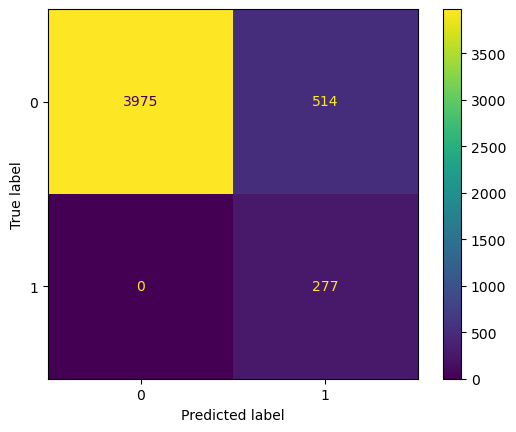

In [43]:
model_1 = grid_search_pipeline(
    pipeline_1,
    extra_params={
        "classifier__C": [0.01, 0.1, 1, 10],
        "classifier__penalty": ["l2", "elasticnet"],
        "classifier__solver": ["liblinear", "lbfgs"],
        "classifier__fit_intercept": [True, False],
        "classifier__class_weight": [class_weights, "balanced"],
        "classifier__l1_ratio": [None, 0.25, 0.5, 0.75],
    },
)
evaluate_model(model_1)

Best params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'preprocessor__cat__onehot__drop': 'first'}
Best AUC: 0.4219968702069198
Accuracy: 0.8459924464960135
Precision: 0.14463452566096424
Recall: 0.33574007220216606
F1 Score: 0.20217391304347826
AUC: 0.8665916604809349


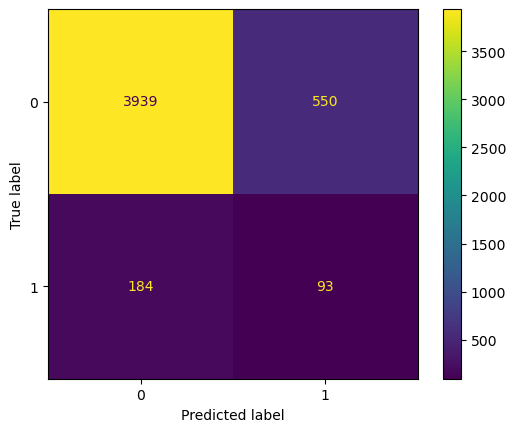

In [44]:
model_2 = grid_search_pipeline(
    pipeline_2,
    extra_params={
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [None, 10, 20],
        "classifier__min_samples_split": [2, 5],
        "classifier__min_samples_leaf": [1, 2],
        "classifier__class_weight": ["balanced", class_weights],
    },
)
evaluate_model(model_2)

/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:59:12] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:59:12] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:59:12] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:59:13] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:

Best params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 15, 'classifier__subsample': 1, 'preprocessor__cat__onehot__drop': None}
Best AUC: 0.654426531789211
Accuracy: 0.9357952161141418
Precision: 0.40268456375838924
Recall: 0.21660649819494585
F1 Score: 0.28169014084507044
AUC: 0.9005736445205408


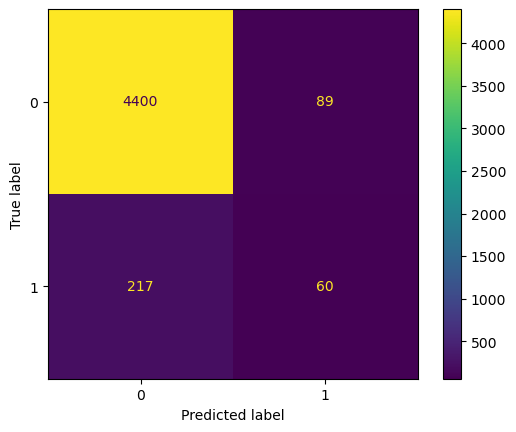

In [45]:
model_3 = grid_search_pipeline(
    pipeline_3,
    extra_params={
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 6, 10],
        "classifier__learning_rate": [0.01, 0.1],
        "classifier__subsample": [0.8, 1],
        "classifier__colsample_bytree": [0.8, 1],
        "classifier__scale_pos_weight": [1, 15],
    },
)
evaluate_model(model_3)

/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/deprec

Best params: {'classifier__colsample_bytree': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_samples': 20, 'classifier__n_estimators': 300, 'classifier__num_leaves': 15, 'classifier__subsample': 0.8, 'preprocessor__cat__onehot__drop': 'first'}
Best AUC: 0.6376160650240255
Accuracy: 0.95132186319765
Precision: 0.5534441805225653
Recall: 0.8411552346570397
F1 Score: 0.667621776504298
AUC: 0.9706575158047791


/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/artem/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


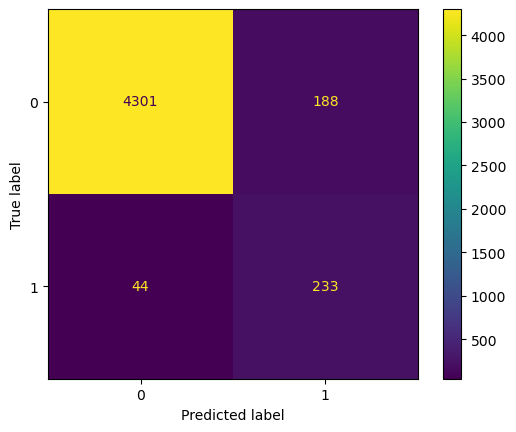

In [ ]:
model_4 = grid_search_pipeline(
    pipeline_4,
    extra_params={
        "classifier__n_estimators": [100, 300],
        "classifier__learning_rate": [0.01, 0.1],
        "classifier__num_leaves": [15, 31, 63],
        "classifier__max_depth": [-1, 10],
        "classifier__min_child_samples": [10, 20],
        "classifier__subsample": [0.8, 1],
        "classifier__colsample_bytree": [0.8, 1],
    },
)
evaluate_model(model_4)

In [49]:
import pickle

def dump_model(model, filename):
    with open(filename, "wb") as f:
        pickle.dump(model, f)


dump_model(model=model_4, filename="../model/model.pkl")